In [96]:
#save model to HuggingFace hub
#https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/mixtral-8x7b-for-web-qa.ipynb

In [97]:
# Helpful links

# https://docs.haystack.deepset.ai/docs/custom-components
# https://docs.haystack.deepset.ai/docs/promptbuilder
# https://github.com/deepset-ai/haystack/blob/main/examples/retrievers/in_memory_bm25_documentsearch.py
# https://github.com/deepset-ai/haystack-tutorials/tree/main/tutorials

In [98]:
import requests
import json
import os
os.environ['TRANSFORMERS_CACHE'] = '/mnt/hf_cache/'
import torch
import glob
import fnmatch
import pandas as pd
import markdown
from html import unescape
from bs4 import BeautifulSoup
import secrets
from haystack import Document, Pipeline
from IPython.display import display, Image

In [99]:
# Collect from GTN

docs = []
directory_path = "../gtn-data/"

def read_md_file_1(path):
    with open(path) as f:
        content = f.read()
        return content

def read_md_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        md_content = file.read()
    return extract_plain_text_from_md(md_content)

def extract_plain_text_from_md(md_content):
    html_content = markdown.markdown(md_content)
    plain_text = ''.join(BeautifulSoup(html_content, "html.parser").findAll(text=True))
    return plain_text.strip()

def generate_hex_id(length):
    random_bytes = secrets.token_bytes(length // 2)
    return random_bytes.hex()
    
#included_content = "/topics/statistics/tutorials/intro_deep_learning/"

included_content = "/topics/"

for root, dirs, files in os.walk(directory_path):
    for filename in files:
        if fnmatch.fnmatch(filename, '*.md'):
            path = os.path.join(root, filename)
            if included_content in path:
                s_path = path.split("/")[-3:]
                tutorial_name = "_".join(s_path)
                md_plain_text = read_md_file(path)
                doc = Document(content=md_plain_text, id=generate_hex_id(10))
                docs.append(doc)

In [100]:
len(docs)

0

In [101]:
# Collect from PRs
# process PRs
for json_file in glob.glob("../out/github_pr_page_*.json"):
    with open(json_file, "r") as fin:
        doc_json = json.load(fin)
        for pr in doc_json:
            pr_text = pr["body"]
            if pr_text != None:
                useful_text_limit = pr_text.find("## How to test the changes")
                if useful_text_limit > 0:
                    pr_text = pr_text[:useful_text_limit].strip()
                    doc = Document(content=pr_text, id=generate_hex_id(10))
                    docs.append(doc)

In [102]:
import random
random.shuffle(docs)

In [103]:
len(docs), docs[:5]

(3654,
 [Document(id=6ba1d75154, content: 'Implement a pinia-based store for the state of running ITs for the given user. 
  
  * refactor the us...'),
  Document(id=7cb52ad716, content: 'When google-cloud-storage is installed in an old version. Fixes https://github.com/galaxyproject/gal...'),
  Document(id=e87a371d0c, content: 'Custos SDK logs various exceptions that that were propagated to the Galaxy log unnecessarily so rest...'),
  Document(id=a59650b47b, content: 'Allows for large projects with many outputs to easily pre-select inputs when using multiple workflow...'),
  Document(id=800dd9e99f, content: 'Fixes https://github.com/galaxyproject/galaxy/issues/15036. The root of the bug is that discovered f...')])

In [104]:
raw_documents = docs[:50]
len(raw_documents)

50

In [141]:
from haystack import Pipeline
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever, InMemoryEmbeddingRetriever
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.utils import ComponentDevice
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder

document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

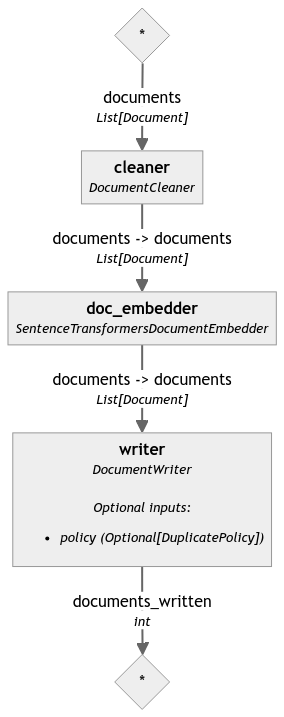

In [142]:
# https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/zephyr-7b-beta-for-rag.ipynb
indexing = Pipeline()
indexing.add_component("cleaner", DocumentCleaner())
#indexing.add_component("splitter", DocumentSplitter(split_by='sentence', split_length=100))
indexing.add_component("doc_embedder", SentenceTransformersDocumentEmbedder(model="thenlper/gte-large",
                                                                            device=ComponentDevice.from_str("cuda:0"), 
                                                                            meta_fields_to_embed=["title"]))
indexing.add_component("writer", DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE))

#indexing.connect("cleaner", "splitter")
#indexing.connect("splitter", "doc_embedder")
#indexing.connect("doc_embedder", "writer")

indexing.connect("cleaner", "doc_embedder")
indexing.connect("doc_embedder", "writer")

In [143]:
#indexing.draw("indexing.png")
#Image(filename='indexing.png')

In [144]:
indexing.run({"cleaner":{"documents": raw_documents}})

Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


{'writer': {'documents_written': 50}}

In [145]:
print(document_store.filter_documents()[0])

Document(id=8ea305d818fc063b7d062396355ba26869dcb8091e098ad4db66c7b4e3449879, content: 'Implement a pinia-based store for the state of running ITs for the given user. * refactor the user I...', embedding: vector of size 1024)


In [146]:
print(document_store.filter_documents()[0])
i = 0
for item in document_store.filter_documents():
    print(item.content)
    i+= 1
    print("==========")
    if i == 50:
       break

Document(id=8ea305d818fc063b7d062396355ba26869dcb8091e098ad4db66c7b4e3449879, content: 'Implement a pinia-based store for the state of running ITs for the given user. * refactor the user I...', embedding: vector of size 1024)
Implement a pinia-based store for the state of running ITs for the given user. * refactor the user IT overview menu to use it * refactor the IT job-submission page to use it * open the interactive tool interface if `eye` icon is clicked on a dataset that has running & active IT * implement a masthead item that subscribes to the store and displays link to ITs if any is running and active ![Galaxy___martenson](https://user-images.githubusercontent.com/1814954/207153120-b3a5f19b-476e-420d-8e33-b8115115e4a0.png)
When google-cloud-storage is installed in an old version. Fixes https://github.com/galaxyproject/galaxy/issues/16012
Custos SDK logs various exceptions that that were propagated to the Galaxy log unnecessarily so restrict those.
Allows for large projects with 

In [147]:
#dir(document_store)

In [148]:
'''
prompt_template = """
    Given these documents, answer the question.\nDocuments:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""
'''
system_message = "Galaxy is a web server to process scientific datasets. Act like a Bioinformatician who uses the Galaxy platform for biological data analysis. Understand the following context and instructions and prepare a suitable response."

prompt_template = system_message + "\n" + "[INST] " + \
                "\n[context]: {% for doc in documents %} {{ doc.content }} {% endfor %}" + \
                "\n[question]: {{query}} " + \
                "[\INST]"

prompt_builder = PromptBuilder(template=prompt_template)

In [149]:
HF_HOME = '/mnt/hf_cache/'

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoModel,
    BitsAndBytesConfig,
    TrainingArguments,
)


#import deepspeed
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer, AutoModel
import torch
from peft import AutoPeftModelForCausalLM, PeftModel

base_dir = "llama-linear-layers-all-conv-Feb-19-24-1"
checkpoint_number = "checkpoint-500"
checkpoint_path = "{}/{}".format(base_dir, checkpoint_number)
model_name = "NousResearch/Llama-2-7b-chat-hf"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype
)

original_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    use_cache=False,
    device_map="auto",
    cache_dir=HF_HOME
)

peft_model = PeftModel.from_pretrained(original_model, checkpoint_path)
#peft_model = peft_model.merge_and_unload()
restored_tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]


In [150]:
from haystack import component

@component
class FineTunedGenerator:
  """
  A component generating query response by fine-tuned LLM
  """
  @component.output_types(response=str)
  def run(self, query:str):
      print("Generating text by fine-tuned LLM...")
      print("Encoding query...")
      input_ids = restored_tokenizer.encode(query, return_tensors="pt").to('cuda')
      print("Generating response...")
      outputs = peft_model.generate(
          input_ids=input_ids,
          max_new_tokens=128,
          do_sample=True,
      )
      pred = restored_tokenizer.decode(outputs[0])
      print("Finished generation")
      return {"response": pred}

In [151]:
generator = FineTunedGenerator()

In [152]:
rag = Pipeline()
rag.add_component("text_embedder", SentenceTransformersTextEmbedder(model="thenlper/gte-large", 
                                                                    device=ComponentDevice.from_str("cuda:0")))
rag.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k=1))
rag.add_component("prompt_builder", prompt_builder)
rag.add_component("llm", instance= FineTunedGenerator())

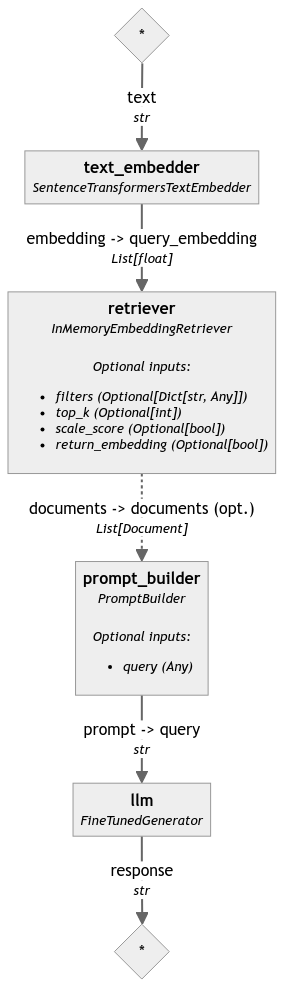

In [153]:
rag.connect("text_embedder", "retriever")
rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder.prompt", "llm")

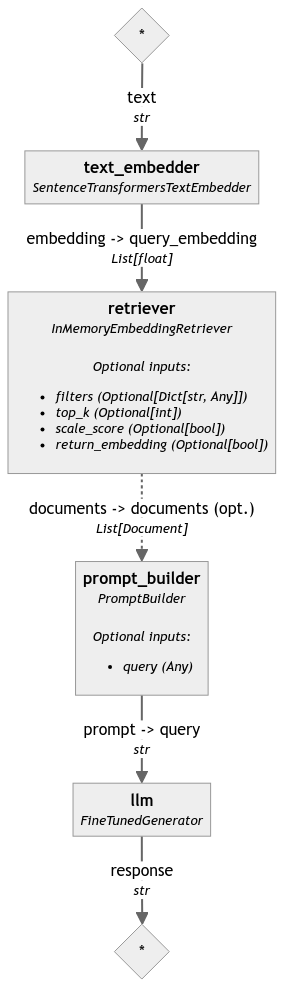

In [154]:
rag.draw("rag.png")
display(Image(filename='rag.png'))

In [155]:
'''query = "I would suggest installing the refseq_masher package. I checked earlier, and found it in the toolshed. \
Please, this package will help a lot."'''

query = "I am analyzing 321 genome but not getting the alignment file. \
I have tried different versions of ROARY and with varying changes in the maximum number of clusters. \
Can you help me with it?"

results = rag.run({
        "text_embedder": {"text": query},
        "prompt_builder": {"query": query}
    }
)

Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.46it/s]


Generating text by fine-tuned LLM...
Encoding query...
Generating response...
Finished generation


In [156]:
from pprint import pprint
answer = results["llm"]["response"]
pprint(answer)

('<s> Galaxy is a web server to process scientific datasets. Act like a '
 'Bioinformatician who uses the Galaxy platform for biological data analysis. '
 'Understand the following context and instructions and prepare a suitable '
 'response.\n'
 '[INST] \n'
 '[context]:  Address '
 'https://github.com/galaxyproject/galaxy/pull/2992/files#r81424455 now that '
 'the imports are no more circular. \n'
 '[question]: I am analyzing 321 genome but not getting the alignment file. I '
 'have tried different versions of ROARY and with varying changes in the '
 'maximum number of clusters. Can you help me with it? [\\INST] i have the '
 'same problem. i tried to run the analysis with 321 genomes and 16 clusters, '
 'but it does not work. i tried to run the analysis with 10 genomes and 16 '
 'clusters, but it does not work. i tried to run the analysis with 10 genomes '
 'and 8 clusters, but it does not work. i tried to run the analysis with 10 '
 'genomes and 4 clusters, but it does not work. i t

In [ ]:
### With Mixtral fine-tuned Zephyr

from haystack.components.generators import HuggingFaceTGIGenerator, HuggingFaceLocalGenerator
from haystack.utils import Secret

model_kwargs = {
    "load_in_4bit":True,
    "bnb_4bit_use_double_quant":True,
    "bnb_4bit_quant_type":"nf4",
    "bnb_4bit_compute_dtype":torch.bfloat16
}

generator = HuggingFaceLocalGenerator(
    "HuggingFaceH4/zephyr-7b-beta", 
    huggingface_pipeline_kwargs={"device_map":"auto",
    "model_kwargs": model_kwargs},
    generation_kwargs={"max_new_tokens": 350},
    #cache_dir=HF_HOME
)
generator.warm_up()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards:   0%|                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

In [ ]:
prompt_template_zep = """
    \nDocuments:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""

prompt_template_zep = system_message + "\n" + prompt_template_zep

prompt_builder_zep = PromptBuilder(template=prompt_template_zep)

In [ ]:
rag_zep = Pipeline()
rag_zep.add_component("text_embedder", SentenceTransformersTextEmbedder(model="thenlper/gte-large", 
                                                                    device=ComponentDevice.from_str("cuda:0")))
rag_zep.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k=1))
rag_zep.add_component("prompt_builder", prompt_builder_zep)
rag_zep.add_component("llm", generator)

In [ ]:
rag_zep.connect("text_embedder", "retriever")
rag_zep.connect("retriever.documents", "prompt_builder.documents")
rag_zep.connect("prompt_builder.prompt", "llm")

In [ ]:
rag_zep.draw("rag_zep.png")
display(Image(filename='rag_zep.png'))

In [ ]:
query = "I am analyzing 321 genome but not getting the alignment file. \
I have tried different versions of ROARY and with varying changes in the maximum number of clusters. \
Can you help me with it?"

results = rag_zep.run({
        "text_embedder": {"text": query},
        "prompt_builder": {"query": query}
    }
)

In [ ]:
from pprint import pprint
answer = results["llm"]["replies"][0]
pprint(answer)